Word2Vec: https://www.kaggle.com/code/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut/notebook

In [66]:
##data_dir = '/content/drive/My Drive/Advance ML/Final Project/'
test_csv = 'https://raw.githubusercontent.com/MatanTsarfaty/AML/main/Copy%20of%20dreaddit-test.csv'
train_csv = 'https://raw.githubusercontent.com/MatanTsarfaty/AML/main/Copy%20of%20dreaddit-train.csv'

In [67]:
import pandas as pd
import numpy as np
import plotly.express as px 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, VarianceThreshold, mutual_info_classif, SelectKBest

In [68]:
import re
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import word2vec, Word2Vec

In [70]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

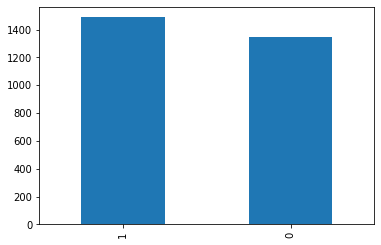

In [71]:
train_df['label'].value_counts().plot(kind='bar')

In [72]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [73]:
values = train_df['subreddit'].value_counts()
labels = train_df['subreddit'].value_counts().index

fig = px.pie(train_df, names=labels, values=values)
fig.update_layout(title='Subreddits distribution')
fig.update_traces(hovertemplate='%{label}: %{value}')
fig.show()

In [74]:
train_df['subreddit']

0                   ptsd
1             assistance
2                   ptsd
3          relationships
4       survivorsofabuse
              ...       
2833       relationships
2834                ptsd
2835             anxiety
2836      almosthomeless
2837                ptsd
Name: subreddit, Length: 2838, dtype: object

In [75]:
label_enc = LabelEncoder()
train_df['subreddit'] = label_enc.fit_transform(train_df['subreddit'])
test_df['subreddit'] = label_enc.fit_transform(test_df['subreddit'])

In [76]:
train_df['subreddit']

0       6
1       2
2       6
3       7
4       9
       ..
2833    7
2834    6
2835    1
2836    0
2837    6
Name: subreddit, Length: 2838, dtype: int64

Take all the 80% majurity data

In [77]:
BestData_ = train_df[train_df['confidence'] >= 0.8]

In [78]:
BestData_.shape

(1852, 116)

In [79]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
import re

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def nospecial(text, remove_spaces=True):
    #return re.sub('[^a-zA-Z0-9 ]', " ", text)
    return re.sub('[^a-zA-Z ]', "", text)

def clean_text(text):
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = nospecial(text)
    return text

In [81]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def preprocess(df):
    df['text'] = df['text'].apply(clean_text)
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.') 
    df['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df.document_sentences))  
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))

In [82]:
preprocess(BestData_)
preprocess(test_df)

In [83]:
#Collecting a vocabulary
voc = []
for sentence in BestData_.tokenized_sentences:
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(BestData_)))

Number of sentences: 1852.
Number of rows: 1852.


Word2Vec model

In [84]:
num_features = 260    
min_word_count = 3
num_workers = 4
context = 8
downsampling = 1e-3

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=10)

In [85]:
def sentence_vectors(model, sentence):
    #Collecting all words in the text
    words=np.concatenate(sentence)
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.

    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

In [86]:
BestData_['sentence_vectors'] = list(map(lambda sen_group: sentence_vectors(W2Vmodel, sen_group), BestData_.tokenized_sentences))
test_df['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test_df.tokenized_sentences))

In [87]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]

In [88]:
X_train_Word2Vec = vectors_to_feats(BestData_, num_features)
X_test_Word2Vec = vectors_to_feats(test_df, num_features)
X_train_Word2Vec.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,0.003173,0.128905,-0.118254,0.262479,-0.004749,-0.052645,-0.094970,0.103198,0.015537,0.082369,...,-0.004693,0.023391,0.026549,0.040421,-0.135240,0.011942,-0.036080,-0.076764,-0.012867,0.070488
1,-0.030564,0.121755,-0.079511,0.211512,-0.044907,0.000815,0.009852,0.120524,-0.039306,0.082335,...,0.005495,0.010279,0.089629,0.104352,-0.154369,-0.007806,-0.033852,-0.043380,-0.009854,0.044631
2,-0.001807,0.141777,-0.089917,0.261122,0.000465,-0.041252,-0.103108,0.133577,0.005212,0.112812,...,0.018776,0.010208,0.022603,0.035391,-0.166990,0.056798,-0.049129,-0.060928,-0.006460,0.077968
4,-0.016178,0.163414,-0.071581,0.234290,-0.010092,-0.047484,-0.088076,0.141064,0.031039,0.106738,...,0.022424,0.002443,0.000743,0.062824,-0.136703,0.039352,-0.026562,-0.072842,0.007232,0.083701
5,0.044520,0.125536,-0.119950,0.267038,-0.024586,-0.058280,-0.124025,0.055979,0.000779,0.074416,...,-0.024426,0.028028,0.019272,0.052202,-0.148652,0.050712,-0.040292,-0.087453,-0.007603,0.072935


In [89]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,896,7,7nu7as,"[50, 55]",its like that want not me i problem takes long...,0,0.8,1.514981e+09,22,-1.238793,...,-0.000369,0.030867,0.041330,0.011793,-0.136843,0.019671,-0.042464,-0.083872,-0.018883,0.072112
1,19059,1,680i6d,"(5, 10)",i man front desk title hr customer service rep...,0,1.0,1.493348e+09,5,7.684583,...,0.006137,0.009055,0.041854,0.064026,-0.157174,0.022251,-0.024587,-0.045205,0.013390,0.054857
2,7977,6,8eeu1t,"(5, 10)",wed saving much money new housrits expensive c...,1,1.0,1.524517e+09,10,2.360408,...,0.003384,0.025025,0.022793,0.048375,-0.160820,0.024898,-0.037973,-0.070018,0.004927,0.079452
3,1214,6,8d28vu,"[2, 7]",my ex used shoot back do want go you time matt...,1,0.5,1.524018e+09,5,5.997000,...,-0.003733,0.029804,0.022355,0.049021,-0.144516,0.034653,-0.050572,-0.073677,-0.018213,0.084307
4,1965,7,7r1e85,"[23, 28]",i havent said anything yet im sure someone wou...,0,0.8,1.516200e+09,138,4.649418,...,-0.002733,0.020049,0.023751,0.041738,-0.134371,0.044668,-0.039298,-0.066431,-0.020523,0.077224


In [90]:
y_train = BestData_['label']
X_train = BestData_.drop('label', axis=1)

In [91]:
y_test = test_df['label']
X_test = test_df.drop('label', axis=1)

In [92]:
X_train = X_train.select_dtypes(include=np.number)

In [93]:
X_test = X_test.select_dtypes(include=np.number)

In [94]:
X_train.shape

(1852, 372)

In [95]:
def best_model(X_train, y_train, X_test, y_test, scaler, algo):
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = algo()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    training_score = model.score(X_train, y_train)
    acc = accuracy_score(y_test, predictions)
    con = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)
    print(f'Training Score: {training_score}')
    print(f'Accuracy Score: {acc}')
    print(" ")
    print('Confusion Matrix:')
    print(con)
    print(" ")
    print('Classification Report:')
    print(report)

## Pearson correlation method

In [96]:
def correlation(df, thres): #Dataset and threshold value
    col_corr = set()
    corr_matrix = df.corr(method='pearson')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= thres:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [97]:
corr_features = correlation(X_train, 0.4)

In [98]:
len(corr_features)

318

In [99]:
X_train[corr_features]

,w2v_130,w2v_227,w2v_197,w2v_27,lex_liwc_sad,lex_liwc_compare,w2v_150,w2v_26,w2v_195,w2v_33,...,lex_liwc_male,w2v_72,lex_liwc_pronoun,w2v_101,w2v_257,lex_liwc_motion,w2v_62,w2v_89,syntax_fk_grade,w2v_165
0,-0.038151,-0.119718,-0.014569,-0.004361,3.45,3.45,0.053435,-0.034159,0.108103,-0.046108,...,1.72,0.020171,16.38,-0.152407,-0.076764,0.86,0.084807,-0.148932,3.253573,-0.020984
1,-0.057654,-0.111745,-0.037917,-0.106176,0.00,0.92,0.083382,0.019920,0.028784,-0.021019,...,0.00,-0.067131,11.93,-0.176179,-0.043380,2.75,0.039518,-0.180112,8.828316,-0.117880
2,-0.081805,-0.159862,-0.020075,-0.027441,0.00,0.60,0.069524,-0.024404,0.094877,-0.051865,...,2.40,0.033587,25.15,-0.111016,-0.060928,4.79,0.052161,-0.116627,7.841667,-0.041650
4,-0.078459,-0.111018,-0.043634,-0.046061,0.00,2.25,0.048093,-0.007980,0.118721,-0.071185,...,4.49,0.016476,15.73,-0.139653,-0.072842,2.25,0.042353,-0.135613,7.910952,-0.026384
5,-0.066888,-0.121554,-0.011407,0.002064,1.90,1.90,0.063207,-0.023015,0.077023,-0.054806,...,3.81,0.047702,20.95,-0.097298,-0.087453,1.90,0.117833,-0.121939,4.338429,-0.040228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,-0.060178,-0.139220,-0.081851,-0.075838,0.00,1.37,0.065495,0.011564,0.073734,-0.058904,...,2.74,-0.026014,9.59,-0.176015,-0.048600,4.11,0.009607,-0.112606,5.993333,-0.025882
2831,-0.039099,-0.184861,-0.036498,-0.036347,0.00,2.34,0.085172,-0.003509,0.088524,-0.031893,...,3.91,0.041479,24.22,-0.144738,-0.063916,1.56,0.023782,-0.089811,10.250250,-0.033352
2833,-0.137558,-0.175234,-0.044070,-0.054841,0.00,3.37,0.064208,-0.017452,0.054925,-0.100853,...,0.00,0.016077,25.84,-0.113434,-0.053835,2.25,0.051823,-0.104987,0.254444,-0.042467
2834,0.006332,-0.099916,-0.000078,0.039198,0.74,1.48,0.044645,-0.031155,0.082935,-0.038867,...,0.00,0.047659,16.30,-0.160245,-0.125373,2.22,0.110643,-0.155598,8.640664,-0.026782


In [100]:
minmax = MinMaxScaler()

In [101]:
best_model(X_train[corr_features], y_train, X_test[corr_features], y_test, minmax, LogisticRegression)

Training Score: 0.8617710583153347
Accuracy Score: 0.772027972027972
 
Confusion Matrix:
[[241 105]
 [ 58 311]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       346
           1       0.75      0.84      0.79       369

    accuracy                           0.77       715
   macro avg       0.78      0.77      0.77       715
weighted avg       0.78      0.77      0.77       715



# Until here is the implementation of the article.

## Now we will use cross-validation to evaluate the model

In [102]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [103]:
x_full_data = pd.concat((X_train, X_test), sort=False).reset_index(drop=True)
y_full_data = pd.concat((y_train, y_test), sort=False).reset_index(drop=True)

In [104]:
def get_models():
  
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', C = 1.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC())
    models['xgboost'] = XGBClassifier(n_estimators = 17, max_depth = 2)
    
    return models

In [105]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

> Model: lr F1 score is 0.83, with a standard deviation of (0.01)
> Model: svm F1 score is 0.83, with a standard deviation of (0.02)
> Model: xgboost F1 score is 0.82, with a standard deviation of (0.02)


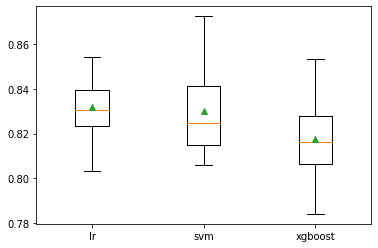

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, x_full_data, y_full_data)
	results.append(scores)
	names.append(name)
	print('> Model: %s F1 score is %.2f, with a standard deviation of (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()